# 手書きカタカナ15文字を自動識別するモデルの構築

### 目的：CNN（畳込みニューラルネットワーク）を使ってカタカナ15文字（ｱｲｳｴｵｶｷｸｹｺｻｼｽｾｿ）を識別します。
#### Create Date：2020/06/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ拡張**](#data_ext)
2. [**データ読込**](#import_data)
3. [**モデル構築**](#modeling)
4. [**モデル評価**](#model_evaluation)
5. [**アップロード結果**](#upload_result)

## 0. Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
import os
import glob
import time
import pickle
import datetime
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from PIL                         import Image
from matplotlib                  import cm
from sklearn.model_selection     import train_test_split
from keras.preprocessing.image   import ImageDataGenerator
from scipy.ndimage.filters       import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

from common.layers               import MultiLayerConvNet,Conv2D,Pool2D
from common.optimizer            import Adam

# ****************************************************************************
# 設定値
# ****************************************************************************
dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}

def get_swap_dict(d):
    return {v: k for k, v in d.items()}
dic_katakana_idx = get_swap_dict(dic_katakana)

# 画像枚数
num_image = 1
# グレースケール
channel = 1
# 画素数
pixel = 28
# 作業ディレクトリ
dir0 = '../1_data'
dir1 = '%s/data_ext/1_png_ext'%(dir0)
dir2 = '%s/data_ext/2_make_npy'%(dir0)
dir3 = '%s/data_ext/3_miss_read'%(dir0)
# 訓練データファイルパス
train_data_path1="%s/train_data.npy"%(dir0)
train_label_path1="%s/train_label.npy"%(dir0)
# データ拡張ファイルパス
train_data_path2="%s/train_data_ext.npy"%(dir2)
train_label_path2="%s/train_label_ext.npy"%(dir2)

# ============================================================================
# 関数：フォルダ作成
# ============================================================================
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

# ============================================================================
# 関数：学習済パラメータ保存
# ============================================================================
def create_param_pickle(snet, file_name):
    save_params = snet.params.copy()
    for layer in snet.layers.keys():
        if('BatchNorm' in layer):
            save_params[layer + '_mv_mu'] = snet.layers[layer].moving_mean
            save_params[layer + '_mv_var'] = snet.layers[layer].moving_var
    with open(file_name, "wb") as f:
        pickle.dump(save_params, f)
    print('save parameter file:',file_name)
    
# ============================================================================
# 関数：numpyファイルの画像をラベル別フォルダに出力（png形式）
# ============================================================================
def output_train_png_data(train_data, train_label):
    idx = 0
    for idx in range(train_data.shape[0]):
        img = train_data[idx,:,:,:,] # 画像
        label = dic_katakana_idx[np.argmax(train_label[idx])] # ラベル
        
        create_dir("%s/%s"%(dir1, label))
        img = Image.fromarray(np.uint8(img.reshape(pixel,pixel)))
        img.save("%s/%s/%s_%s.png"%(dir1, label, label, str(idx).zfill(4)))

    print(str(train_data.shape[0]) + ' files output done!')
    
# ============================================================================
# 関数：画像ファイルをnumpy形式で保存
# ============================================================================
def save_numpy_file(data_path, label_path):
    X = [] # 画像
    Y = [] # ラベル
    
    for label in dic_katakana.keys():        
        files = glob.glob("%s/%s/"%(dir1, label) + "/*.png")
        
        for i, file in enumerate(files):

            # numpy形式に変換(1,28,28形式)
            data = np.empty((1, pixel, pixel))
            img_ = Image.open(file)
            img_ = np.array(img_).astype(np.float32)
            data[0, :] = img_

            # 格納
            X.append(data)
            Y.append(dic_katakana[label])

    X = np.array(X)
    Y = np.array(Y)
    Y = np.eye(15)[Y] # one-hot変換

    #numpy形式で保存
    np.save(data_path,X)
    np.save(label_path,Y)
    
    # データ作成結果
    df = pd.DataFrame(data=np.argmax(Y, axis=1), columns=['label'])
    df['label']=df['label'].replace(dic_katakana_idx)
    display(pd.DataFrame(df['label'].value_counts(),columns=['label']))
    
# ============================================================================
# 関数：弾性変形
# ============================================================================
def elastic_transform(image, alpha_range, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

Using TensorFlow backend.


# 1. データ拡張<a id='data_ext'></a>

- データの前処理として、[ImageDataGenerator](https://keras.io/ja/preprocessing/image/)クラスを利用したデータ拡張を行いました。
- まず配布されているカタカナ3000画像（15文字×200画像）をpng形式で展開し、カタカナの文字ごとに、以下ImageDataGeneratorの引数の値を少しずつ変えて増幅して出力しました。
- なお、出力枚数は、サーバー上のテストデータの比率の違いにより、文字ごとに作成枚数を変えています。

#### ＜ImageDataGeneratorの主な利用引数＞
- **rotation_range：** 整数。画像をランダムに回転する回転範囲。
- **width_shift_range：** 浮動小数点数（横幅に対する割合）。ランダムに水平シフトする範囲。
- **height_shift_range：** 浮動小数点数（縦幅に対する割合）。ランダムに垂直シフトする範囲。
- **shear_range：** せん断：浮動小数点数。シアー強度（反時計回りのシアー角度）。
- **zoom_range：** ランダムにズームする範囲。主に縮小を利用。
- **preprocessing_function(elastic_transform)：** 弾性変形は、人間の手書きのバリエーションを模倣するのに適しています。 MNISTデータセットに弾性歪みを適用する方法は、「Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis」でSimard、Steinkraus、およびPlattin（2003）によって説明されています。(preprocessing_functionは他の変更が行われる前に実行されます。)

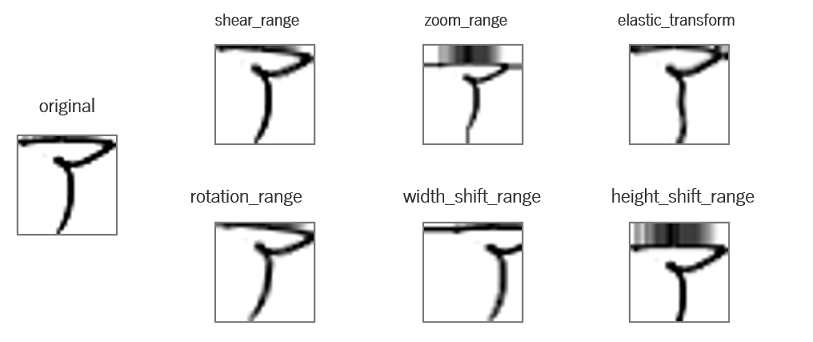

In [2]:
# データ拡張のイメージ
Image.open('../3_img/Sample_image.png')

In [3]:
# ============================================================================
# 拡張データ作成
# ============================================================================
def create_ImageDataGenerator(ext_num1, ext_num2):
    
    # クリア
    for file in glob.glob('%s/*/*_EXT_*.png'%(dir1), recursive=True):
        os.remove(file)
        
    for label in dic_katakana.keys():
        
        files = glob.glob("%s/%s/"%(dir1, label) + "/*.png")        
        
        for i,fname in enumerate(files):
            
            # 画像読込（numpy形式）
            data = np.empty((num_image, channel, pixel, pixel)) # 配列初期化
            img_ = Image.open(fname)
            img_ = np.array(img_).astype(np.float32)
            data[0, 0, :] = img_
            
            # 軸をN,H,W,Cに入替
            data = data.transpose(0,2,3,1)
            
            # ImageDataGeneratorのオブジェクト生成
            datagen = None
            if(label in ['a','u','e','o']):        
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=10,        # 回転
                        width_shift_range=0.05,   # 水平シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            if(label in ['e']):        
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=7,         # 回転 10 →7
                        width_shift_range=0.05,    # 水平シフト
                        height_shift_range=0.05,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            if(label in ['i']):        
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断 0.2→0.1
                        rotation_range=8,         # 回転 10→8
                        width_shift_range=0.1,    # 水平シフト
                        height_shift_range=0.1,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['ka']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=10,         # 回転 15→10
                        width_shift_range=0.05,    # 水平シフト
                        height_shift_range=0.05,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['ki','ku','ke']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,           # せん断
                        rotation_range=15,         # 回転
                        width_shift_range=0.03,    # 水平シフト
                        height_shift_range=0.03,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                )
            elif(label in ['ko']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=5,          # 回転
                        zoom_range = [1.0,1.1],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['sa']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=10,         # 回転 15→10
                        width_shift_range=0.01,    # 水平シフト
                        height_shift_range=0.01,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['si','se']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=15,         # 回転
                        width_shift_range=0.05,    # 水平シフト
                        height_shift_range=0.05,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['su']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=15,         # 回転
                        width_shift_range=0.05,    # 水平シフト
                        height_shift_range=0.05,   # 垂直シフト
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )
            elif(label in ['so']):
                datagen = ImageDataGenerator(rescale=1./255,
                        shear_range=0.3,          # せん断
                        rotation_range=15,        # 回転
                        zoom_range = [1.0,1.2],   # 縮小・拡大
                        preprocessing_function=lambda x: elastic_transform(x, alpha_range=[8,9], sigma=3) # 弾性変形
                )

            # 生成
            g = datagen.flow(data, save_to_dir="%s/%s/"%(dir1, label), save_format='png',
                             save_prefix='%s_EXT'%(os.path.basename(fname).replace('.png','')))
            
            if(label in ['a','i','u','e','o']):
                for i in range(ext_num1):
                    batches = g.next()
            else:
                for i in range(ext_num2):
                    batches = g.next()
                
    print('create_ImageDataGenerator complete!')

In [4]:
# 作業ディレクトリクリア
for file in glob.glob('%s/*/*.png'%(dir1), recursive=True):
    os.remove(file)

# 訓練データpng出力
output_train_png_data(np.load(train_data_path1), np.load(train_label_path1))

# 拡張データ生成
create_ImageDataGenerator(9,8)

28000 files output done!


# 2. データ読込<a id='import_data'></a>

- データ拡張した画像を読込み、正規化してホールドアウト法でデータ分割（７：３）します。

In [5]:
# 拡張データ保存
save_numpy_file(train_data_path2, train_label_path2)

# numpy形式読込
train_data = np.load(train_data_path2)
train_label = np.load(train_label_path2)

print('train_data:',train_data.shape)
print('train_label:',train_label.shape)

# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

# データ分割
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=1234, shuffle=True)

print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test :',X_test.shape)
print('y_test',y_test.shape)

while True:
    word = input('\ncheck ! train data ： ')
    if(word == 'ok'):
        break

,label
i,2000
e,2000
u,2000
a,2000
o,2000
sa,1800
so,1800
ke,1800
su,1800
ka,1800


train_data: (28000, 1, 28, 28)
train_label: (28000, 15)
X_train: (19600, 1, 28, 28)
y_train: (19600, 15)
X_test : (8400, 1, 28, 28)
y_test (8400, 15)

check ! train data ： ok


# 3. モデル構築<a id='modeling'></a>

- 採用したモデルは、LeNet (1998：Yann LeCun)と同じ7層からなる以下のモデル（イメージ図参照）です。
（構成：1.畳込み層、2.プーリング層、3.畳込み層、4.プーリング層、5.全結合層、6.全結合層、7.出力層　※フィルタ、ノード数等の設定は異なる）
- このモデルは、割と計算時間がかからず、高い汎化性能が得られました。
- 畳込み層とアフィン層の後には、いずれもバッチ正規化を入れています。
- MultiLayerConvNetクラスは、正則化のために荷重減衰（L2ノルム）とドロップアウトを実装していますが、使用しなくても高い汎化性能が得られました。
- 最適化手法は、**adam**を利用しています。

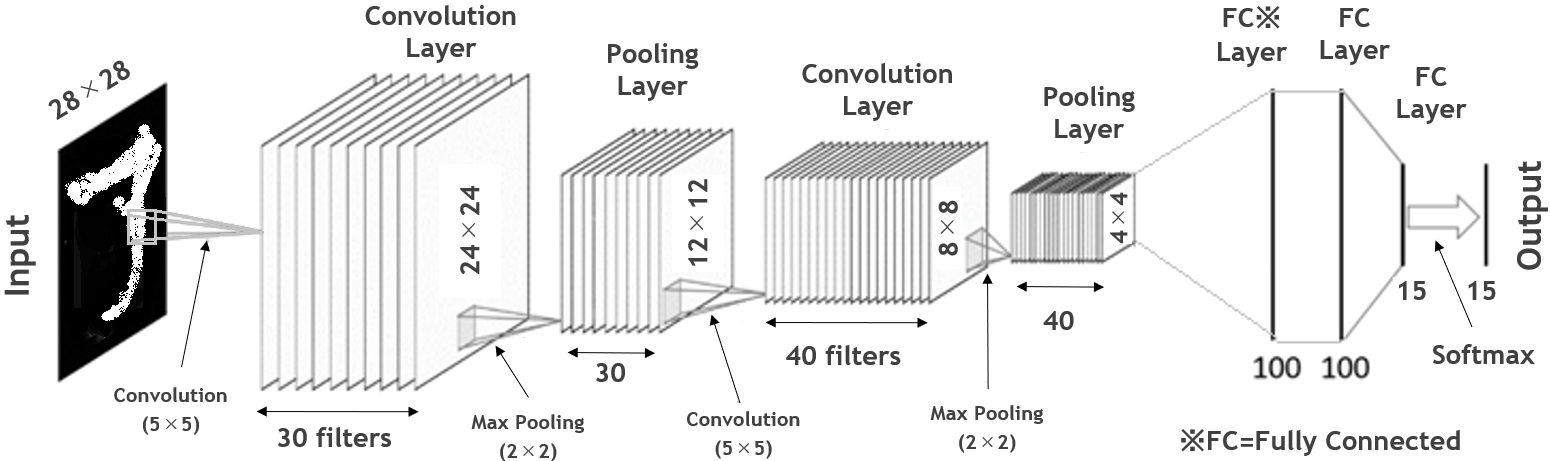

In [6]:
# モデルイメージ図
Image.open('../3_img/CNN_image.png')

----------------------------------------------------
self.use_batchnorm <-------------------- True
self.weight_d_lmda <-------------------- 0.0
self.use_dropout <---------------------- False
self.dropout_ration <------------------- 0.0
self.hidden_size_list <----------------- [100, 100]
----------------------------------------------------
out_size <------------------------------ [28, 24, 12, 8, 4]
out_pixel <----------------------------- 640
----------------------------------------------------
Conv111 <------------------------------- W111: (30, 1, 5, 5) b111: (30,)
BatchNorm111 <-------------------------- gamma111: (30,) beta111: (30,)
ReLU111 <-------------------------------
Pool111 <-------------------------------
Conv121 <------------------------------- W121: (40, 30, 5, 5) b121: (40,)
BatchNorm121 <-------------------------- gamma121: (40,) beta121: (40,)
ReLU121 <-------------------------------
Pool121 <-------------------------------
Affine211 <----------------------------- W211:

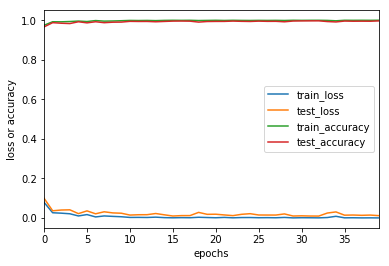

,train_loss,test_loss,train_accuracy,test_accuracy
0,0.078599,0.099377,0.974694,0.966429
1,0.026190,0.036143,0.992398,0.987738
2,0.024061,0.039998,0.992092,0.984881
3,0.021044,0.041066,0.993571,0.983214
4,0.010039,0.021787,0.995816,0.992262
5,0.016969,0.035678,0.993520,0.986786
6,0.005108,0.020911,0.998367,0.992381
7,0.010067,0.031080,0.995510,0.987619
8,0.007850,0.025448,0.996224,0.990119
9,0.005966,0.023798,0.997602,0.990595


In [7]:
# 計測開始
start_fit = time.time()

epochs = 40
batch_size = 32

xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# CNN
snet = MultiLayerConvNet(input_dim=(1, 28, 28), cnn_layers_list=[
    {'Conv111':Conv2D(filter_num=30,filter_size=5,pad=0,stride=1)},
    {'Pool111':Pool2D(pool_size=2,pad=0,stride=2)},
    {'Conv121':Conv2D(filter_num=40,filter_size=5,pad=0,stride=1)},
    {'Pool121':Pool2D(pool_size=2,pad=0,stride=2)}],                    
    hidden_size_list=[100,100],
    output_size=15, weight_init_std=0.01, use_batchnorm=True, weight_decay_lambda=0.00,
    use_dropout=False, dropout_ration=0.0)
    
# 最適化手法
optimizer = Adam(lr=0.001, rho1=0.9, rho2=0.999)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        
        # ミニバッチ生成
        mask = idx[batch_size*it : batch_size*(it+1)]    
        x_train = X_train[mask]
        t_train = y_train[mask]
        
        # 勾配の計算 (誤差逆伝播法) 
        grads = snet.gradient(x_train, t_train)
        
        # パラメータ更新
        optimizer.update(snet.params, grads)
        
    # 学習経過記録
    train_loss.append(snet.loss(X_train,  y_train))
    test_loss.append(snet.loss(X_test, y_test))
    train_accuracy.append(snet.accuracy(X_train, y_train, train_flg=True))
    test_accuracy.append(snet.accuracy(X_test, y_test, train_flg=True))
    
    print('epoch = {:d}/{:d}  (batch_size：{:d}) --- time(m) = {:.1f} ---> train_acc = {:.4f} , test_acc = {:.4f}'
          .format(epoch, epochs-1, batch_size, (time.time() - start_fit)/60,train_accuracy[-1],test_accuracy[-1]))

    if(test_accuracy[-1] > 0.9955):
        create_param_pickle(snet, "katakana_model_" + str(test_accuracy[-1])  + ".pickle")

print('-----------------------------------------------')
# パラメータ保存
create_param_pickle(snet, "katakana_model.pickle")

# 計算時間
print('\ntime(m)：{:.2f}'.format((time.time() - start_fit) / 60)) 

# 学習曲線
df_log = pd.DataFrame({"train_loss":train_loss, "test_loss":test_loss, 
                       "train_accuracy":train_accuracy, "test_accuracy":test_accuracy})
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()
display(df_log)

# 4.モデル評価<a id='model_evaluation'></a>

- 学習曲線から、過学習が抑えられていることがわかります。Epoc数は、30回前後で高い精度が得られました。（35回以降は、大きな性能変化がみられませんでした。※最大50epoc試行）
- カとクとケが間違えやすいようです。
- 読込に失敗した画像を取得し、人間が見て判別可能な場合、再度、学習データに利用したり、データ拡張の枚数を増やしたりしました。
- また、読込に失敗した画像が、人間が見て判別不可能な場合、データ拡張の設定値を変更しました。
- 総じて、データ拡張の画像を変更、増加させることで、汎化性能が向上しました。


▼ Miss Read Count ： 24
ka -->  6
ku -->  4
u --->  3
ke -->  2
se -->  2
e --->  2
ki -->  2
su -->  1
sa -->  1
si -->  1

▼ Miss Read Image：
miss_read： ku  ---> correct： ke


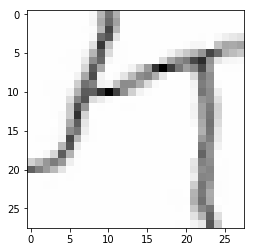

miss_read： ke  ---> correct： ka


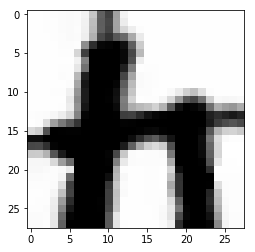

miss_read： ku  ---> correct： su


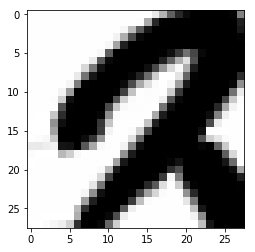

miss_read： ke  ---> correct： ka


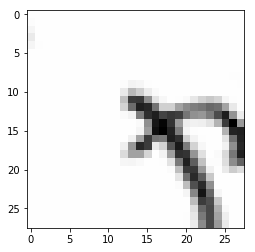

miss_read： ka  ---> correct： se


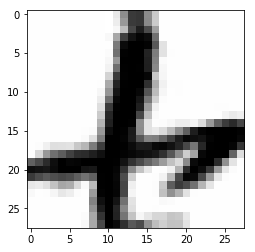

miss_read： ke  ---> correct： ka


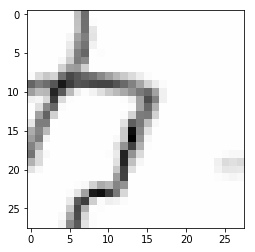

miss_read： ke  ---> correct： sa


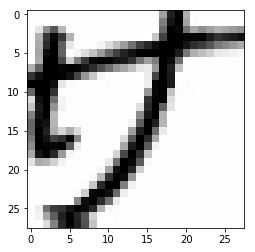

miss_read： ko  ---> correct： e


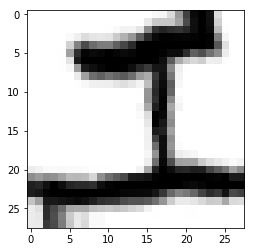

miss_read： ke  ---> correct： ku


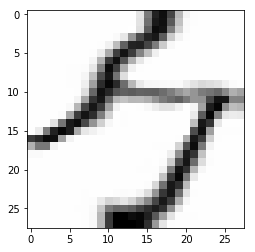

miss_read： ku  ---> correct： u


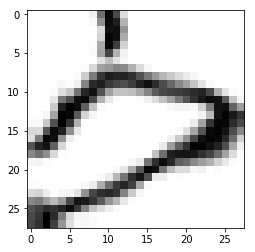

miss_read： ke  ---> correct： ku


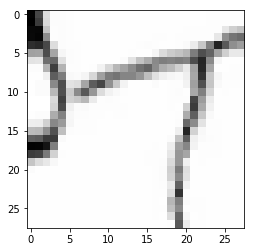

miss_read： ku  ---> correct： ke


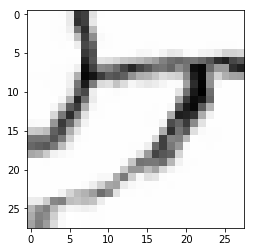

miss_read： se  ---> correct： u


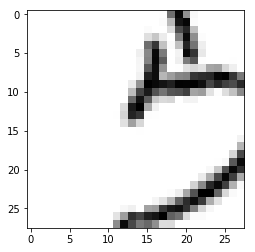

miss_read： ku  ---> correct： u


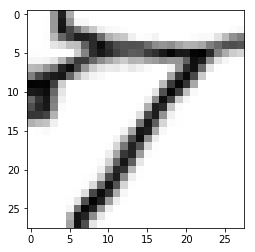

miss_read： u  ---> correct： ku


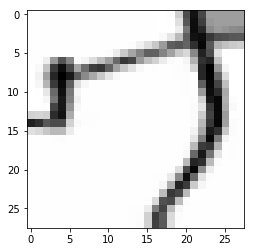

miss_read： ke  ---> correct： ku


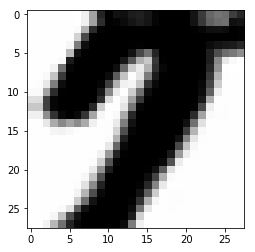

miss_read： ku  ---> correct： ka


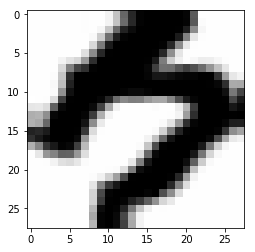

miss_read： su  ---> correct： ki


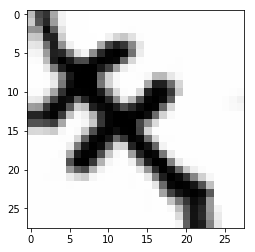

miss_read： o  ---> correct： ki


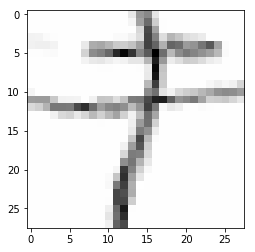

miss_read： ku  ---> correct： ka


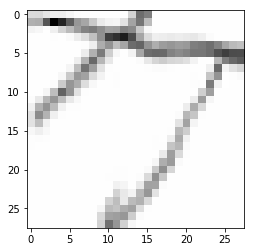

miss_read： o  ---> correct： ka


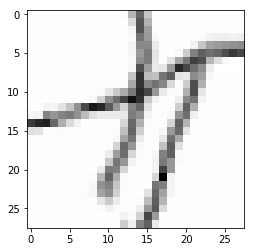

miss_read： so  ---> correct： si


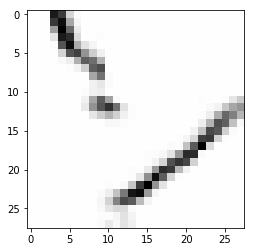

miss_read： i  ---> correct： e


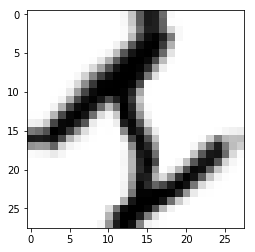

miss_read： ka  ---> correct： se


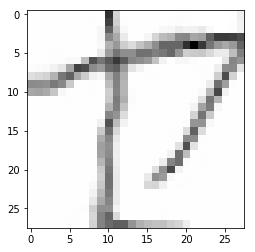

NG_file output.： 20200611_2243


In [8]:
# 不正解データ出力
ng_dic, ng_img_list, miss_read_lbl_list, correct_lbl_list = snet.get_miss_read_data(X_test, y_test)
yyyyMMdd_HHmm = datetime.datetime.now().strftime('%Y%m%d_%H%M')

print('\n▼ Miss Read Count ：', len(correct_lbl_list))
for k in sorted(ng_dic,key=ng_dic.get, reverse=True):
    print((k + ' -').ljust(5,'-') + '> ',ng_dic[k])
    
print('\n▼ Miss Read Image：')
create_dir("%s/%s"%(dir3, yyyyMMdd_HHmm))
for idx,label in enumerate(correct_lbl_list):
    print('miss_read：',miss_read_lbl_list[idx],' ---> correct：',label)
    data = ng_img_list[idx]
    img = data[0,:,:] * 255.0 # 正規化を戻す
    plt.imshow(img, cmap='gray')
    plt.show()
    
    create_dir("%s/%s/%s"%(dir3, yyyyMMdd_HHmm,label))
    img = Image.fromarray(np.uint8(img.reshape(pixel,pixel)))
    img.save("%s/%s/%s/%s_NG5_%s.png"%(dir3, yyyyMMdd_HHmm,label,label,str(idx).zfill(4)))

print('NG_file output.：',yyyyMMdd_HHmm)

# 5. アップロード結果<a id='upload_result'></a>

- 現時点での汎化性能の値は以下になりました。
- まだまだ人間には読める字を間違えている為、より豊富なバリエーションのデータ拡張を行うことでさらに精度が上がることが予想されますが、テストデータに適合するデータ拡張の設定が手探り状態なところが難しいです。

**▼ 中間発表時点**
- Test loss:0.08499986691436578
- Test accuracy:0.9841379310344828